Goal: use a decision tree model to predict the relaxed energy of catalysts. 

Pipeline:
- data inspection & cleaning
- hot encoding (not all features are numeric) 
- correlation analysis (feature reduction) ??
- principal component analysis (for visualization) ??
- cross validation
- hyperparameter tuning & model selection
- final model evaluation
- feature importance
- exploitation

In [29]:
import pandas as pd
import matplotlib.pyplot as plt


df_h = pd.read_csv('data/training_FULL_h_all_featurized.csv')
df_no_ads = pd.read_csv('data/training_FULL_no_ads_all_featurized.csv')

print(df_h.shape)
print(df_no_ads.shape)

(1605, 488)
(14646, 488)


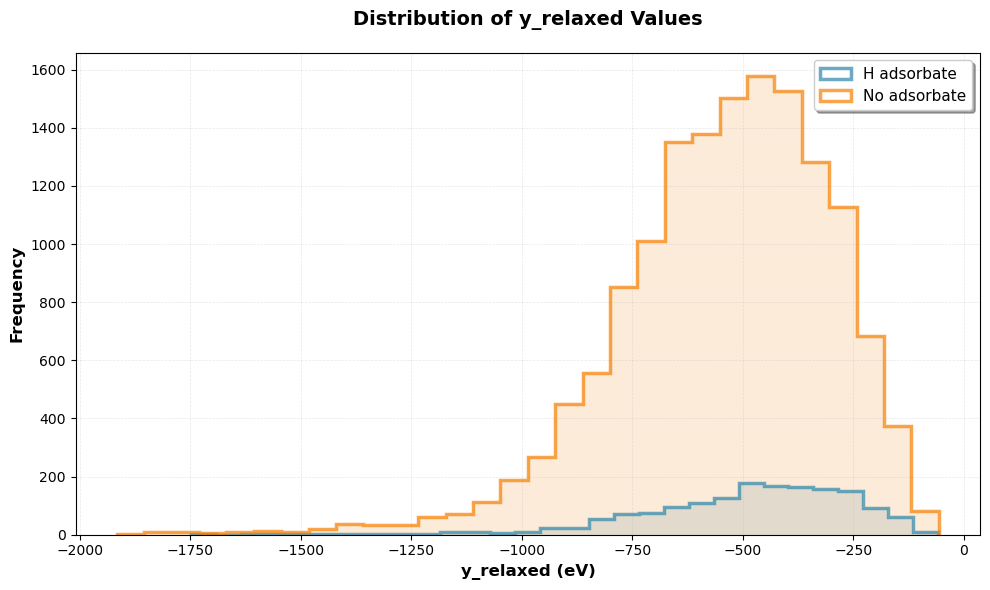

In [30]:
# Create figure with better size and resolution
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

# Plot histograms as step curves (no overlap issues)
ax.hist(df_h['y_relaxed'], bins=30, alpha=0.7, color='#2E86AB', label='H adsorbate', histtype='step', linewidth=2.5)
ax.hist(df_no_ads['y_relaxed'], bins=30, alpha=0.7, color='#F77F00', label='No adsorbate', histtype='step', linewidth=2.5)

# Optional: add fill under the lines for better visibility
ax.hist(df_h['y_relaxed'], bins=30, alpha=0.15, color='#2E86AB', histtype='stepfilled')
ax.hist(df_no_ads['y_relaxed'], bins=30, alpha=0.15, color='#F77F00', histtype='stepfilled')

ax.set_xlabel('y_relaxed (eV)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Distribution of y_relaxed Values', fontsize=14, fontweight='bold', pad=20)

ax.legend(loc='upper right', frameon=True, shadow=True, fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

In [35]:
print(f"columns in h-ads dataset before: {df_h.shape[1]}")
print(f"columns in no-ads dataset before: {df_no_ads.shape[1]}")
print(f"rows in h-ads dataset before: {df_h.shape[0]}")
print(f"rows in no-ads dataset before: {df_no_ads.shape[0]}")

# get features (columns) with all NaN values
nan_cols_h = df_h.columns[df_h.isna().all()].tolist()
nan_cols_no_ads = df_no_ads.columns[df_no_ads.isna().all()].tolist()

# get features with all 0 values
h_num_cols = df_h.select_dtypes(include='number')
h_zero_cols = h_num_cols.columns[h_num_cols.eq(0).all()]

no_ads_num_cols = df_no_ads.select_dtypes(include='number')
no_ads_zero_cols = no_ads_num_cols.columns[no_ads_num_cols.eq(0).all()]

print("----")
print("Columns with all NaN values in h-ads dataset:", nan_cols_h)
print("Columns with all NaN values in no-ads dataset:", nan_cols_no_ads)
print("Columns with all 0 values in h-ads dataset:", h_zero_cols)
print("Columns with all 0 values in no-ads dataset:", no_ads_zero_cols)

# drop NaN columns
df_h_clean_col = df_h.drop(columns=nan_cols_h)
df_no_ads_clean_col = df_no_ads.drop(columns=nan_cols_no_ads)

# drop all-0 columns
df_h_clean_col = df_h_clean_col.drop(columns=h_zero_cols)
df_no_ads_clean_col = df_no_ads_clean_col.drop(columns=no_ads_zero_cols)

# drop rows with no structure data
df_h_clean = df_h_clean_col.dropna(subset=['structure']).reset_index(drop=True)
df_no_ads_clean = df_no_ads_clean_col.dropna(subset=['structure']).reset_index(drop=True)

print("----")
print(f"columns in h-ads dataset after cleaning: {df_h_clean.shape[1]}")
print(f"columns in no-ads dataset after cleaning: {df_no_ads_clean.shape[1]}")

print(f"rows in h-ads dataset after cleaning: {df_h_clean.shape[0]}")
print(f"rows in no-ads dataset after cleaning: {df_no_ads_clean.shape[0]}")

columns in h-ads dataset before: 488
columns in no-ads dataset before: 488
rows in h-ads dataset before: 1605
rows in no-ads dataset before: 14646
----
Columns with all NaN values in h-ads dataset: []
Columns with all NaN values in no-ads dataset: []
Columns with all 0 values in h-ads dataset: Index(['MagpieData minimum NdValence', 'MagpieData minimum NfValence',
       'MagpieData minimum NsUnfilled', 'MagpieData minimum NdUnfilled',
       'MagpieData minimum NfUnfilled', 'MagpieData mode NfUnfilled',
       'MagpieData minimum GSbandgap', 'MagpieData mode GSbandgap',
       'MagpieData minimum GSmagmom'],
      dtype='object')
Columns with all 0 values in no-ads dataset: Index(['MagpieData minimum NdValence', 'MagpieData minimum NfValence',
       'MagpieData minimum NsUnfilled', 'MagpieData minimum NdUnfilled',
       'MagpieData minimum NfUnfilled', 'MagpieData minimum GSbandgap',
       'MagpieData minimum GSmagmom'],
      dtype='object')
----
columns in h-ads dataset after clea

In [36]:
# separate dataframe into features, identifiers, and target
h_id = df_h_clean[['bulk_id', 'bulk_symbols', 'structure']]
h_y = df_h_clean['y_relaxed']
h_X = df_h_clean.drop(columns=['bulk_id', 'bulk_symbols', 'y_relaxed', 'structure'])

df_no_ads_clean = df_no_ads_clean.reset_index()
no_ads_id = df_no_ads_clean[['bulk_id', 'bulk_symbols', 'structure']]
no_ads_y = df_no_ads_clean['y_relaxed']
no_ads_X = df_no_ads_clean.drop(columns=['bulk_id', 'bulk_symbols', 'y_relaxed', 'structure'])

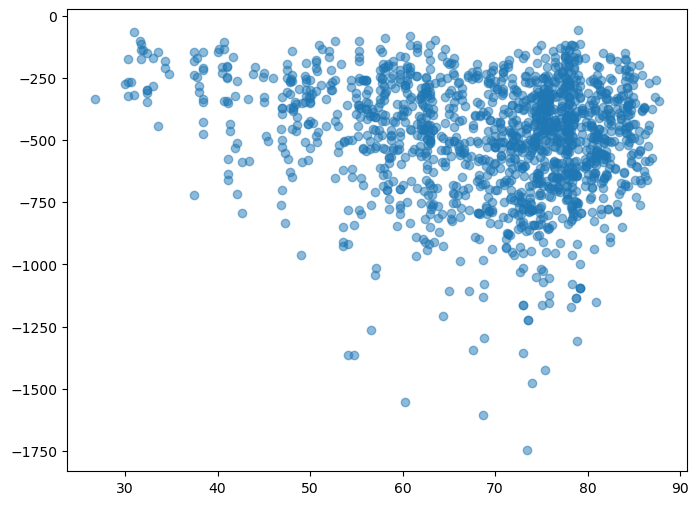

In [80]:
plt.figure(figsize=(8, 6))
plt.scatter(h_X[h_X.columns[9]], h_y, alpha=0.5)
plt.show()

In [49]:
# Make sure X and y are aligned
print(len(h_X), len(h_y))
print(h_X.index.equals(h_y.index))

print(len(no_ads_X), len(no_ads_y))
print(no_ads_X.index.equals(no_ads_y.index))

1514 1514
True
13651 13651
True


In [51]:
# Check your target distribution
print(h_y.describe())
print(f"h_y has missing values? {h_y.isna().sum()}")  # Any missing values?
print(f"f_y has 0 values? {(h_y == 0).sum()}")  # Many zeros?

count    1514.000000
mean     -489.035436
std       230.391320
min     -1747.629416
25%      -628.646698
50%      -458.624650
75%      -318.433886
max       -59.024696
Name: y_relaxed, dtype: float64
h_y has missing values? 0
f_y has 0 values? 0


## Hot encode

need to do this for correlation analysis. Otherwise, decision tree models do not need hot-encoded datasets.

In [89]:
encoded_h_X = pd.get_dummies(h_X)
encoded_no_ads_X = pd.get_dummies(no_ads_X)

print(f"Number of features after encoding: {encoded_h_X.shape[1]}")
print(f"Number of samples: {encoded_h_X.shape[0]}")

Number of features after encoding: 579
Number of samples: 1514


In [90]:
encoded_h_X.head()

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,LUMO_element_Zr,crystal_system_cubic,crystal_system_hexagonal,crystal_system_monoclinic,crystal_system_orthorhombic,crystal_system_tetragonal,crystal_system_triclinic,crystal_system_trigonal,is_centrosymmetric_False,is_centrosymmetric_True
0,8.0,30.0,22.0,15.142857,8.489796,8.0,2.0,87.0,85.0,57.571429,...,False,False,False,False,False,True,False,False,True,False
1,8.0,75.0,67.0,31.000000,27.600000,8.0,9.0,87.0,78.0,64.800000,...,False,True,False,False,False,False,False,False,False,True
2,8.0,30.0,22.0,19.000000,11.000000,8.0,69.0,87.0,18.0,78.000000,...,False,False,True,False,False,False,False,False,True,False
3,8.0,29.0,21.0,17.625000,9.625000,8.0,43.0,87.0,44.0,72.875000,...,False,False,False,True,False,False,False,False,False,True
4,8.0,24.0,16.0,13.428571,6.204082,8.0,49.0,87.0,38.0,74.857143,...,False,False,False,False,True,False,False,False,False,True


## Correlation Analysis

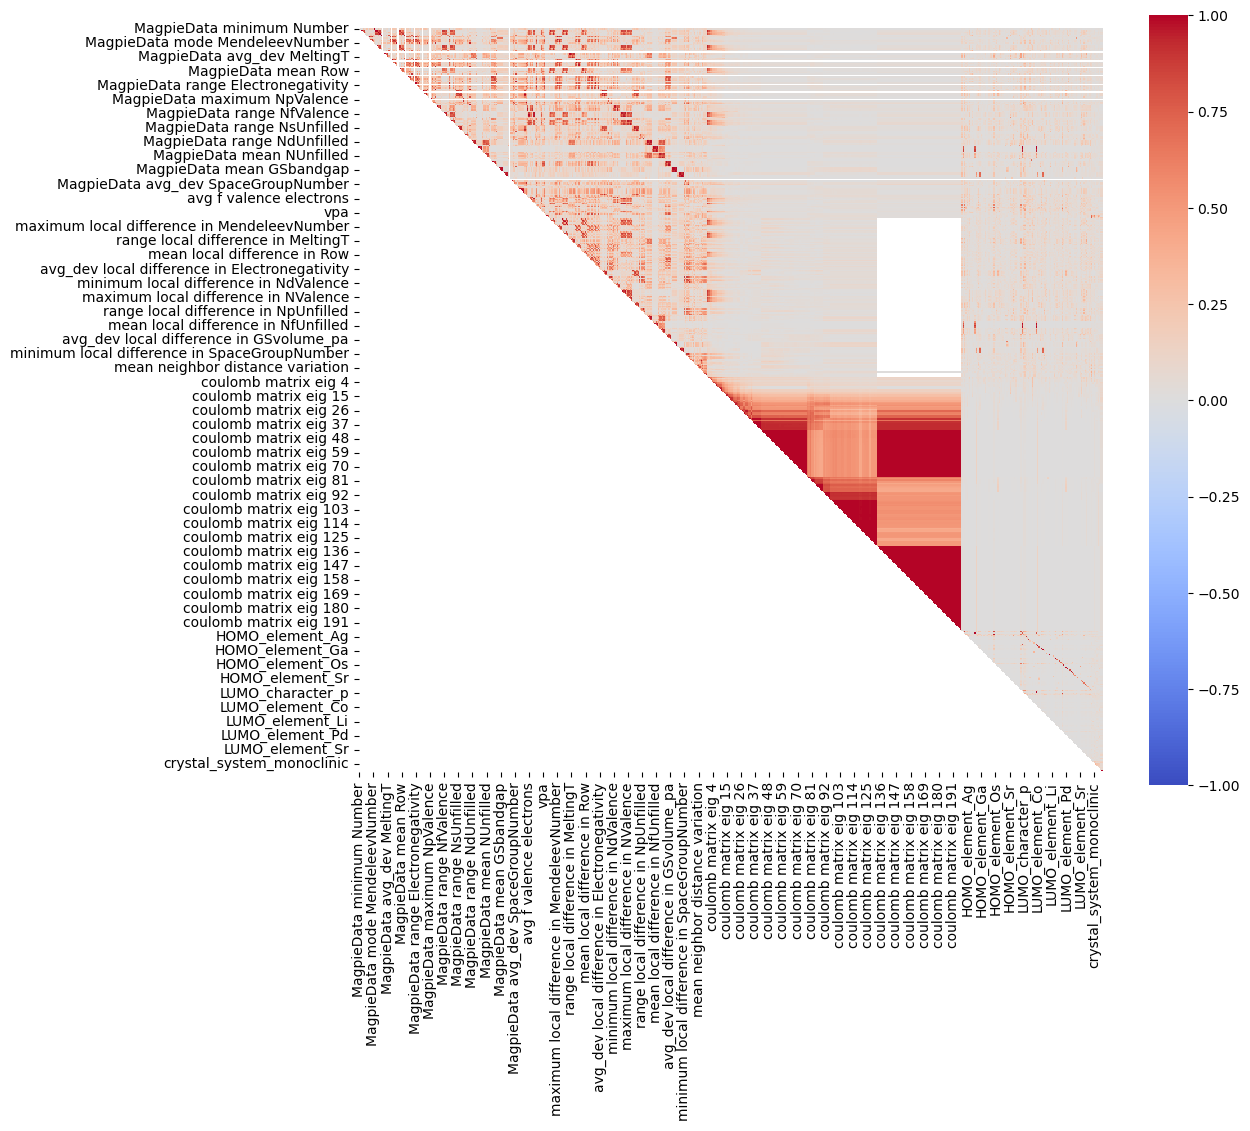

In [41]:
import seaborn as sns
import numpy as np

h_corr_mat = encoded_h_X.corr().abs()
upper_tri = h_corr_mat.where(np.triu(np.ones(h_corr_mat.shape), k=1).astype(bool)) 

plt.figure(figsize=(12, 10))
sns.heatmap(upper_tri, cmap='coolwarm', center=0, vmin=-1, vmax=1, square=True)
plt.show()

*TO-DO:*

find a way to drop highly correlated features. Model is overfitting.

## Cross Validation

simplest way is to use cross_val_score()
if cv argument is an integer, cross_val_score uses KFold or StratifiedKFold.
Can also use other cross alidation strategies by passing a cross validation iterator or by defining a custom iterable yielding (train, test) splits as arrays of indices.

cross_val_score vs. gridsearchCV?

In [57]:
from sklearn.model_selection import train_test_split

h_X_train, h_X_test, h_y_train, h_y_test = train_test_split(
    encoded_h_X, 
    h_y, 
    test_size=0.2, 
    random_state=1065)

no_ads_X_train, no_ads_X_test, no_ads_y_train, no_ads_y_test = train_test_split(
    encoded_no_ads_X, 
    no_ads_y, 
    test_size=0.2, 
    random_state=1065)

In [59]:
from sklearn.dummy import DummyRegressor


h_baseline = DummyRegressor(strategy='mean')
h_baseline.fit(h_X_train, h_y_train)
print(f"h-ads Baseline R²: {h_baseline.score(h_X_train, h_y_train)}")

no_ads_baseline = DummyRegressor(strategy='mean')
no_ads_baseline.fit(no_ads_X_train, no_ads_y_train)
print(f"no-ads Baseline R²: {h_baseline.score(no_ads_X_train, no_ads_y_train)}")

h-ads Baseline R²: 0.0
no-ads Baseline R²: -0.0697222761650349


In [69]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

h_dt = DecisionTreeRegressor()
no_ads_dt = DecisionTreeRegressor()

param_grid = {
    'max_depth' : [None, 3, 5, 7, 10, 15, 20],
    'min_samples_split' : [2, 4, 6, 8, 10, 12, 16, 18, 20],
    'min_samples_leaf' : [1, 2, 4, 5, 10, 15, 20],
    'max_features' : [None, 'sqrt', 'log2'],
}

h_grid = GridSearchCV(
    estimator=h_dt,
    param_grid = param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

no_ads_grid = GridSearchCV(
    estimator=h_dt,
    param_grid = param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

h_grid.fit(h_X_train, h_y_train)
no_ads_grid.fit(no_ads_X_train, no_ads_y_train)

print('h-ads Best params: ', h_grid.best_params_)
print('no-ads best params: ', no_ads_grid.best_params_)

# get tuned models
h_tuned_model = h_grid.best_estimator_
no_ads_tuned_model = no_ads_grid.best_estimator_

# CV with tuned models
h_scores = cross_val_score(h_tuned_model, h_X_train, h_y_train, cv=5, scoring='r2')
no_ads_scores = cross_val_score(no_ads_tuned_model, no_ads_X_train, no_ads_y_train, cv=5, scoring='r2')

Fitting 5 folds for each of 1323 candidates, totalling 6615 fits
Fitting 5 folds for each of 1323 candidates, totalling 6615 fits
h-ads Best params:  {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20, 'min_samples_split': 20}
no-ads best params:  {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 12}


In [66]:
print("--- h-ads dataset ---")
print(f"h-ads training R²: {h_tuned_model.score(h_X_train, h_y_train)}")
print(f'h-ads CV R^2 scores: {h_scores}')
print(f"h-ads best CV R²: {h_grid.best_score_}")

print("--- no-ads dataset ---")
print(f"no-ads training R²: {no_ads_tuned_model.score(no_ads_X_train, no_ads_y_train)}")
print(f'no-ads CV R^2 scores: {no_ads_scores}')
print(f"no-ads best CV R²: {no_ads_grid.best_score_}")

--- h-ads dataset ---
h-ads training R²: 0.4644972520972628
h-ads CV R^2 scores: [0.28158253 0.24685583 0.21554985 0.13527853 0.34411966]
h-ads best CV R²: 0.310946224837301
--- no-ads dataset ---
no-ads training R²: 0.6458818901645293
no-ads CV R^2 scores: [0.4417593  0.43217448 0.45383465 0.46936743 0.46098024]
no-ads best CV R²: 0.45896156375348146


In [68]:
h_feature_importance = pd.DataFrame({
    'feature': encoded_h_X.columns,
    'importance': h_tuned_model.feature_importances_
}).sort_values('importance', ascending=False)

print(h_feature_importance.head(20))
print(f"\nTop 10 features capture {h_feature_importance.head(10)['importance'].sum():.2%} of importance")

                                       feature  importance
88                 MagpieData range NdUnfilled    0.394731
286                      coulomb matrix eig 15    0.073568
99                   MagpieData mean NUnfilled    0.063740
74                 MagpieData avg_dev NValence    0.056098
106             MagpieData avg_dev GSvolume_pa    0.044013
151            mean local difference in Number    0.030792
309                      coulomb matrix eig 38    0.025500
222     avg_dev local difference in NpUnfilled    0.024408
260                   min relative bond length    0.024285
127                                     7-norm    0.019686
310                      coulomb matrix eig 39    0.019303
155  range local difference in MendeleevNumber    0.018503
142                                    density    0.016670
20                   MagpieData range MeltingT    0.016422
52                MagpieData avg_dev NsValence    0.016391
279                       coulomb matrix eig 8    0.0153

## Regression

Here I define the model pipeline that will be used for CV and final model evaluation.

In [ ]:
# hot-encodes the categorical structure features.
# this code is generated by ChatGPT and I am not sure exactly how it works
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline


# get the part of the dataframe that is obj data type (which is a string)
is_obj = h_X.dtypes == 'object'
h_X_obj = h_X.loc[:, is_obj]

# OneHotCoder transforms each categorical feature with (n_categories) possible values
# into n_categories binary features.
h_preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), h_X_obj.columns)
    ],
    remainder='passthrough' # columns not specified in transformers will be untouched.
    # since we are only passing in the categorical columns, this shouldn't matter
)

# calling model.fit() and it will automatically encode the inputs
h_model = Pipeline([
    ('preprocess', h_preprocess),
    ('regression', DecisionTreeRegressor())])